In [9]:
import sys
sys.path.append("../")

In [15]:
from utils.text_splitter import TextSplitter
from utils.chroma_store import ChromaStore
from chromadb.utils import embedding_functions
from transformers import pipeline
import pandas as pd
import time
import uuid
import requests
import json
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option('max_colwidth', 800)

In [19]:
### Parameters
data_version = "data/third_version"  # It does not exist on remote (so we will use local)
USE_FULL_DATASET = True
DEFAULT_EMBED_INSTRUCTION = "Represent the document for retrieval: "
DEFAULT_QUERY_INSTRUCTION = (
    "Represent the question for retrieving supporting documents: "
)

chroma_client = ChromaStore(chroma_server_hostname="localhost", chroma_server_port=8000)

EMBED_MODEL = "hkunlp/instructor-base"
LLM_MODEL = "google/flan-t5-xl"
N_RESULTS = 3
OPENLLM_ENDPOINT = "http://localhost:3000/v1/generate"

QUESTIONS = [
"Can you tell me about depression?",
"What lifestyle changes are suggested for depression?",
"Are there different types of depressions?"
]

TEMPLATE = """You are a highly skilled AI trained in language comprehension and summarisation.
I would like you to read the following text and summarise it into a concise abstract paragraph. Use the following pieces of context to answer the question at the end.
Aim to retain the most important points, providing a coherent and readable summary that could help a person understand the main points of the discussion without needing to read the entire text.
Please avoid unnecessary details or tangential points.
{context}
Question: {question}
Answer:"""

MAX_OUTPUT_LENGTH = 300
TEMPERATURE = 0.1

Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.


In [12]:
nhs_data = pd.read_csv('../data/nhs_data_validated.csv')
mind_data = pd.read_csv('../data/mind_data_validated.csv')

print(f"Length of NHS dataset: {len(nhs_data)}")
print(f"Length of Mind dataset: {len(mind_data)}")

Length of NHS dataset: 176
Length of Mind dataset: 404


In [13]:
def split_using_chunking(df, chunk_size, chunk_overlap):
    texts = df["text_scraped"].values.tolist()
    src_urls = df["url"].values.tolist()

    print(f"Using chunk_size={chunk_size} and chunk_overlap={chunk_overlap}")
    text_splitter = TextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    chunks, metadatas = [], []
    for text, url in zip(texts, src_urls):
        split_chunks = text_splitter.split_text(text)
        chunks.extend(split_chunks)
        metadatas.extend(
            [
                {"source": url, "data_version": data_version}
                for _ in range(len(split_chunks))
            ]
        )

    uuids = [str(uuid.uuid4()) for _ in range(len(chunks))]
    return uuids, chunks, metadatas

def add_chroma(chunk_size, chunk_overlap, enable_chunking):
    ef_embed = embedding_functions.InstructorEmbeddingFunction(model_name=EMBED_MODEL, instruction=DEFAULT_EMBED_INSTRUCTION)

    start = time.perf_counter()
    for df, collection_name in zip([nhs_data, mind_data], ['nhs_collection', 'mind_collection']):
        print(f"Inserting data into collection {collection_name}")
        print(f"Chunking enabled = {enable_chunking}")
        
        if enable_chunking:
            uuids, chunks, metadatas = split_using_chunking(df, chunk_size, chunk_overlap)
        
        else:
            uuids = df["uuid"].values.tolist()
            chunks = df["text_scraped"].values.tolist()
            src_urls = df["url"].values.tolist()
            metadatas = [{"source": url, "data_version": data_version} for url in src_urls]
            
        chroma_client.add_texts(
            collection_name=collection_name,
            texts=chunks,
            ids=uuids,
            metadatas=metadatas,
            embedding_function=ef_embed,
        )    
    print(f"Time taken to insert data in chroma store {time.perf_counter()-start} sec")


def query_chroma(collection_name, query_text):
    ef_query = embedding_functions.InstructorEmbeddingFunction(model_name=EMBED_MODEL, instruction=DEFAULT_QUERY_INSTRUCTION)

    result_dict = chroma_client.query_collection(
        collection_name=collection_name,
        query_texts=query_text,
        n_results=N_RESULTS,
        embedding_function=ef_query,
    )
    documents = " ".join(result_dict["documents"][0])
    return documents


def query_llm(input_text):
    payload = {"prompt": str(input_text), "llm_config": {"temperature": TEMPERATURE, "max_new_tokens": MAX_OUTPUT_LENGTH}}
    response = requests.post(url=OPENLLM_ENDPOINT,
                             data=json.dumps(payload),
                             headers={"Content-Type": "application/json"}
                            )
    return str(json.loads(response.text)["responses"][0])


def get_llm_prompt_response(questions, enable_chunking, is_new_experiment, fixed_context=False, chunk_size = 1000, chunk_overlap = 200):
    
    collection_names = chroma_client.list_collection_names()
    # Delete any existing data from chroma store
    if is_new_experiment:
        print(f"Found {len(collection_names)} collections")
        for collection_name in collection_names:
            chroma_client.delete_collection(collection_name)
        
        add_chroma(chunk_size, chunk_overlap, enable_chunking)

    collection_names = sorted(chroma_client.list_collection_names())

    results = []
    for query_text in questions:
        responses = []
        for collection_name in collection_names:
            print(f"Collection name: {collection_name}")
    
            if fixed_context:
                context = mind_fixed_context if 'mind' in collection_name else nhs_fixed_context
                print("Using fixed context for LLM prompt")
            else:
                context = query_chroma(collection_name, query_text)
        
            prompt = TEMPLATE.format(question=query_text, context=context)
        
            print("="*100)
            print("LLM prompt")
            print(prompt)

            response = query_llm(prompt)
        
            print("="*100)
            print("LLM Response")
            print(response)
            print("="*100)

            responses.append(response)
        results.append(responses)

    results_df = pd.DataFrame(results, columns=['mind_response', 'nhs_response'])
    results_df['question'] = questions
    return results_df

## Distribution for lengths

Run the following cells only if `USE_FULL_DATASET` is set to `True`.

### NHS dataset

Average length of text in NHS dataset is 3751 words. Considering all texts are of the same length, we add these texts in vector store and get 4 nearest neighbours for query question. This puts length of context = 15004 words (3751 x 4).

Text(0.5, 0.98, 'Histogram for length distribution NHS data')

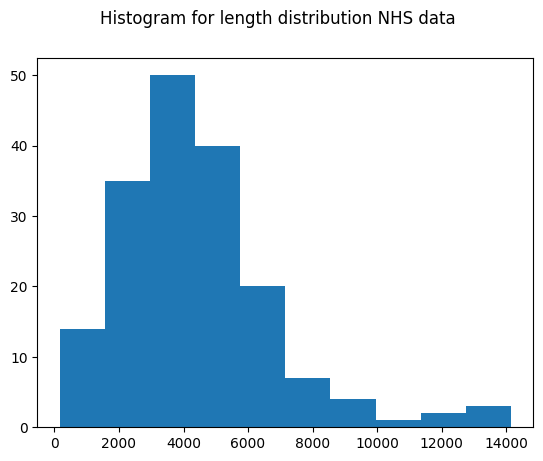

In [5]:
nhs_data['text_scraped'].apply(len).hist(grid=False)
plt.suptitle("Histogram for length distribution NHS data")

In [6]:
nhs_data['text_scraped'].str.len().describe()

count      176.000000
mean      4361.636364
std       2454.280648
min        168.000000
25%       2848.000000
50%       3855.000000
75%       5265.250000
max      14144.000000
Name: text_scraped, dtype: float64

### Mind dataset

Average length of text in Mind dataset is 4965 words. Considering all texts are of the same length, we add these texts in vector store and get 4 nearest neighbours for query question. This puts length of context = 19860 words (4965 x 4).

Text(0.5, 0.98, 'Histogram for length distribution Mind data')

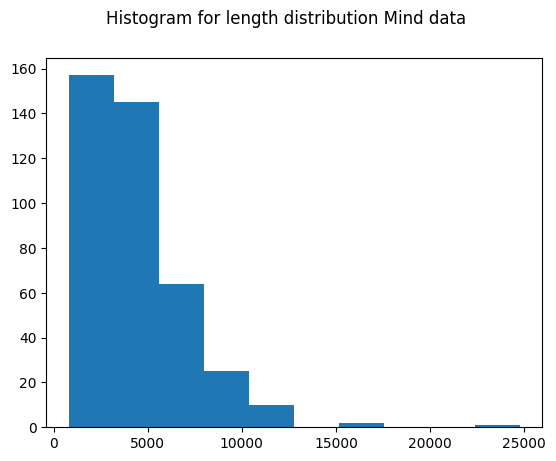

In [7]:
mind_data['text_scraped'].apply(len).hist(grid=False)
plt.suptitle("Histogram for length distribution Mind data")

In [8]:
mind_data['text_scraped'].str.len().describe()

count      404.000000
mean      4414.551980
std       2679.925071
min        807.000000
25%       2223.500000
50%       3820.000000
75%       5603.000000
max      24753.000000
Name: text_scraped, dtype: float64

## Experiments

> Note: This requires a local chroma store running in the background. To run a chroma store server, run the following steps

```bash
docker pull ghcr.io/chroma-core/chroma:0.4.3
docker run -it -p 8000:8000 ghcr.io/chroma-core/chroma:0.4.3
```

This will start chroma server on localhost at port 8000.

In [38]:
results_df = get_llm_prompt_response(QUESTIONS, enable_chunking = False, is_new_experiment = True, fixed_context = True)

Found 2 collections
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
Inserting data into collection nhs_collection
Chunking enabled = False
Inserting data into collection mind_collection
Chunking enabled = False
Time taken to insert data in chroma store 1.7204358110029716 sec
Collection name: mind_collection
Using fixed context for LLM prompt
LLM prompt
Question: Can you tell me about depression?

Context: Depression
Learn about depression, its symptoms and possible causes, and how you can access treatment and support. Find tips on caring for yourself, and guidance for friends and family.

What is depression?
Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things. It can also cause a range of other changes to how you feel or behave.

The symptoms you experience may vary. How intense they are, how long they last, and how much they affect your daily life can also vary.

If

Token indices sequence length is longer than the specified maximum sequence length for this model (1427 > 512). Running this sequence through the model will result in indexing errors


LLM Response
It's a mental health problem that involves having a low mood or losing interest and enjoyment in things.
Collection name: nhs_collection
Using fixed context for LLM prompt
LLM prompt
Question: Can you tell me about depression?

Context: Overview - Depression in adults Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days. Some people think depression is trivial and not a genuine health condition. They're wrong – it is a real illness with real symptoms. Depression is not a sign of weakness or something you can "snap out of" by "pulling yourself together". The good news is that with the right treatment and support, most people with depression can make a full recovery. These pages are about depression in adults. Read about depression in children and young people .

How to tell if you have depression Depression 

Token indices sequence length is longer than the specified maximum sequence length for this model (1631 > 512). Running this sequence through the model will result in indexing errors


LLM Response
Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days.
Collection name: mind_collection
Using fixed context for LLM prompt
LLM prompt
Question: What lifestyle changes are suggested for depression?

Context: Depression
Learn about depression, its symptoms and possible causes, and how you can access treatment and support. Find tips on caring for yourself, and guidance for friends and family.

What is depression?
Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things. It can also cause a range of other changes to how you feel or behave.

The symptoms you experience may vary. How intense they are, how long they last, and how much they affect your daily life can also vary.

If you experience milder depression, you might have low mood but still be able to c

Token indices sequence length is longer than the specified maximum sequence length for this model (1428 > 512). Running this sequence through the model will result in indexing errors


LLM Response
Reduce your tobacco use and alcohol intake
Collection name: nhs_collection
Using fixed context for LLM prompt
LLM prompt
Question: What lifestyle changes are suggested for depression?

Context: Overview - Depression in adults Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days. Some people think depression is trivial and not a genuine health condition. They're wrong – it is a real illness with real symptoms. Depression is not a sign of weakness or something you can "snap out of" by "pulling yourself together". The good news is that with the right treatment and support, most people with depression can make a full recovery. These pages are about depression in adults. Read about depression in children and young people .

How to tell if you have depression Depression affects people in different ways and can ca

Token indices sequence length is longer than the specified maximum sequence length for this model (1632 > 512). Running this sequence through the model will result in indexing errors


LLM Response
getting more exercise and cutting down on alcohol
Collection name: mind_collection
Using fixed context for LLM prompt
LLM prompt
Question: Are there different types of depressions?

Context: Depression
Learn about depression, its symptoms and possible causes, and how you can access treatment and support. Find tips on caring for yourself, and guidance for friends and family.

What is depression?
Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things. It can also cause a range of other changes to how you feel or behave.

The symptoms you experience may vary. How intense they are, how long they last, and how much they affect your daily life can also vary.

If you experience milder depression, you might have low mood but still be able to carry on with your daily life. But things may feel harder and less worthwhile.

If you have more severe depression, you might find day-to-day life much more difficult. You may also expe

Token indices sequence length is longer than the specified maximum sequence length for this model (1428 > 512). Running this sequence through the model will result in indexing errors


LLM Response
There are some other types of depression too.
Collection name: nhs_collection
Using fixed context for LLM prompt
LLM prompt
Question: Are there different types of depressions?

Context: Overview - Depression in adults Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days. Some people think depression is trivial and not a genuine health condition. They're wrong – it is a real illness with real symptoms. Depression is not a sign of weakness or something you can "snap out of" by "pulling yourself together". The good news is that with the right treatment and support, most people with depression can make a full recovery. These pages are about depression in adults. Read about depression in children and young people .

How to tell if you have depression Depression affects people in different ways and can cause a wi

Token indices sequence length is longer than the specified maximum sequence length for this model (1632 > 512). Running this sequence through the model will result in indexing errors


LLM Response
There are different types of depression, and some conditions where depression may be one of the symptoms. These include: postnatal depression – sometimes new mothers, fathers or partners develop depression after they have a baby; this is known as postnatal depression and it's treated in a similar way to other types of depression, with talking therapies and antidepressant medicines


In [41]:
results_df

,mind_response,nhs_response,question
0,It's a mental health problem that involves having a low mood or losing interest and enjoyment in things.,"Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days.",Can you tell me about depression?
1,Reduce your tobacco use and alcohol intake,getting more exercise and cutting down on alcohol,What lifestyle changes are suggested for depression?
2,There are some other types of depression too.,"There are different types of depression, and some conditions where depression may be one of the symptoms. These include: postnatal depression – sometimes new mothers, fathers or partners develop depression after they have a baby; this is known as postnatal depression and it's treated in a similar way to other types of depression, with talking therapies and antidepressant medicines",Are there different types of depressions?


### Chunking

Question: Does chunking improve results?

### chunk_size = 2000 and chunk_overlap = 50

In [20]:
results_df = get_llm_prompt_response(QUESTIONS, enable_chunking = True, is_new_experiment = True, chunk_size = 2000, chunk_overlap = 50)

Collection name: mind_collection
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
LLM prompt
You are a highly skilled AI trained in language comprehension and summarisation.
I would like you to read the following text and summarise it into a concise abstract paragraph. Use the following pieces of context to answer the question at the end.
Aim to retain the most important points, providing a coherent and readable summary that could help a person understand the main points of the discussion without needing to read the entire text.
Please avoid unnecessary details or tangential points.
What is depression? Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things. It can also cause a range of other changes to how you feel or behave. The symptoms you experience may vary. How intense they are, how long they last, and how much they affect your daily life can also vary. If you expe

In [21]:
results_df

,mind_response,nhs_response,question
0,Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things.,"Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days.",Can you tell me about depression?
1,Eat healthily. Exercise regularly. Avoid recreational drugs and alcohol. Take care of your hygiene. Spend time in nature. Eat regularly. Try some physical activity. Visit a recovery college. Medication,"Getting more exercise, cutting down on alcohol, giving up smoking and eating healthily.",What lifestyle changes are suggested for depression?
2,There are different types of depression.,"There are different types of depression, and some conditions where depression may be one of the symptoms.",Are there different types of depressions?


### chunk_size = 1000 and chunk_overlap = 50

In [22]:
results_df = get_llm_prompt_response(QUESTIONS, enable_chunking = True, is_new_experiment = True, chunk_size = 1000, chunk_overlap = 50)

Found 2 collections
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
Inserting data into collection nhs_collection
Chunking enabled = True
Using chunk_size=1000 and chunk_overlap=50
Inserting data into collection mind_collection
Chunking enabled = True
Using chunk_size=1000 and chunk_overlap=50
Time taken to insert data in chroma store 594.1749796719996 sec
Collection name: mind_collection
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
LLM prompt
You are a highly skilled AI trained in language comprehension and summarisation.
I would like you to read the following text and summarise it into a concise abstract paragraph. Use the following pieces of context to answer the question at the end.
Aim to retain the most important points, providing a coherent and readable summary that could help a person understand the main points of the discussion without needing to read the 

In [23]:
results_df

,mind_response,nhs_response,question
0,Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things.,"Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days.",Can you tell me about depression?
1,Try mindfulness.,"Many people with depression benefit by making lifestyle changes, such as getting more exercise, cutting down on alcohol, giving up smoking and eating healthily.",What lifestyle changes are suggested for depression?
2,There are different types of depression.,"There are different types of depression, and. There are many different types available.",Are there different types of depressions?


### chunk_size = 1500 and chunk_overlap = 50

In [24]:
results_df = get_llm_prompt_response(QUESTIONS, enable_chunking = True, is_new_experiment = True, chunk_size = 1500, chunk_overlap = 50)

Found 2 collections
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
Inserting data into collection nhs_collection
Chunking enabled = True
Using chunk_size=1500 and chunk_overlap=50
Inserting data into collection mind_collection
Chunking enabled = True
Using chunk_size=1500 and chunk_overlap=50
Time taken to insert data in chroma store 662.9316993860011 sec
Collection name: mind_collection
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
LLM prompt
You are a highly skilled AI trained in language comprehension and summarisation.
I would like you to read the following text and summarise it into a concise abstract paragraph. Use the following pieces of context to answer the question at the end.
Aim to retain the most important points, providing a coherent and readable summary that could help a person understand the main points of the discussion without needing to read the 

In [25]:
results_df

,mind_response,nhs_response,question
0,Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things.,"Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days.",Can you tell me about depression?
1,"Look after your physical health. Try to get enough sleep. Think about your diet. Eating regularly and keeping your blood sugar stable can make a difference to your mood and energy levels. Try and take some exercise. If you are experiencing physical symptoms you may find it difficult to exercise, but research has shown that exercise can help reduce symptoms of depression. You may also find that it might help you to relax.","Many people with depression benefit by making lifestyle changes, such as getting more exercise, cutting down on alcohol, giving up smoking and eating healthily.",What lifestyle changes are suggested for depression?
2,There are many different mental health problems.,"There are different types of depression, and some conditions where depression may be one of the symptoms.",Are there different types of depressions?


### chunk_size = 1000 and chunk_overlap = 300

In [26]:
results_df = get_llm_prompt_response(QUESTIONS, enable_chunking = True, is_new_experiment = True, chunk_size = 1000, chunk_overlap = 300)

Found 2 collections
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
Inserting data into collection nhs_collection
Chunking enabled = True
Using chunk_size=1000 and chunk_overlap=300
Inserting data into collection mind_collection
Chunking enabled = True
Using chunk_size=1000 and chunk_overlap=300
Time taken to insert data in chroma store 765.5753590570002 sec
Collection name: mind_collection
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
LLM prompt
You are a highly skilled AI trained in language comprehension and summarisation.
I would like you to read the following text and summarise it into a concise abstract paragraph. Use the following pieces of context to answer the question at the end.
Aim to retain the most important points, providing a coherent and readable summary that could help a person understand the main points of the discussion without needing to read th

In [27]:
results_df

,mind_response,nhs_response,question
0,"Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things. It can also cause a range of other changes to how you feel or behave. The symptoms you experience may vary. How intense they are, how long they last, and how much they affect your daily life can also vary. If you experience milder depression, you might have low mood but still be able to carry on with your daily life. But things may feel harder and less worthwhile. If you have more severe depression, you might find day-to-day life much more difficult. You may also experience suicidal feelings.","Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days.",Can you tell me about depression?
1,Getting good sleep. Getting active. Avoiding recreational drugs and alcohol. Getting a healthy diet.,"Getting more exercise, cutting down on alcohol, as painkillers, or any nutritional supplements.",What lifestyle changes are suggested for depression?
2,There are some other types of depression too.,"There are different types of depression, and some conditions where depression may be one of the symptoms.",Are there different types of depressions?


### chunk_size = 1500 and chunk_overlap = 300

In [28]:
results_df = get_llm_prompt_response(QUESTIONS, enable_chunking = True, is_new_experiment = True, chunk_size = 1500, chunk_overlap = 300)

Found 2 collections
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
Inserting data into collection nhs_collection
Chunking enabled = True
Using chunk_size=1500 and chunk_overlap=300
Inserting data into collection mind_collection
Chunking enabled = True
Using chunk_size=1500 and chunk_overlap=300
Time taken to insert data in chroma store 674.4684825020013 sec
Collection name: mind_collection
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
LLM prompt
You are a highly skilled AI trained in language comprehension and summarisation.
I would like you to read the following text and summarise it into a concise abstract paragraph. Use the following pieces of context to answer the question at the end.
Aim to retain the most important points, providing a coherent and readable summary that could help a person understand the main points of the discussion without needing to read th

In [29]:
results_df

,mind_response,nhs_response,question
0,Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things.,"Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days.",Can you tell me about depression?
1,"Sleep, diet and exercise.","Many people with depression benefit by making lifestyle changes, such as getting more exercise, cutting down on alcohol, giving up smoking and eating healthily",What lifestyle changes are suggested for depression?
2,There are some other types of depression too.,"There are different types of depression, and some conditions where depression may be one of the symptoms.",Are there different types of depressions?


### chunk_size = 2000 and chunk_overlap = 300

In [30]:
results_df = get_llm_prompt_response(QUESTIONS, enable_chunking = True, is_new_experiment = True, chunk_size = 2000, chunk_overlap = 300)

Found 2 collections
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
Inserting data into collection nhs_collection
Chunking enabled = True
Using chunk_size=2000 and chunk_overlap=300
Inserting data into collection mind_collection
Chunking enabled = True
Using chunk_size=2000 and chunk_overlap=300
Time taken to insert data in chroma store 645.5280753850002 sec
Collection name: mind_collection
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
LLM prompt
You are a highly skilled AI trained in language comprehension and summarisation.
I would like you to read the following text and summarise it into a concise abstract paragraph. Use the following pieces of context to answer the question at the end.
Aim to retain the most important points, providing a coherent and readable summary that could help a person understand the main points of the discussion without needing to read th

In [31]:
results_df

,mind_response,nhs_response,question
0,Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things.,"Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days. Some people think depression is trivial and not a genuine health condition. They're wrong – it is a real illness with real symptoms. Depression is not a sign of weakness or something you can ""snap out of"" by ""pulling yourself together"". The good news is that with the right treatment and support, most people with depression can make a full recovery.",Can you tell me about depression?
1,Getting good sleep. Getting good food and drink. Getting some physical activity. Avoiding recreational drugs and alcohol. Taking care of your hygiene. Creating a creative space. Getting some physical activity.,"Getting more exercise, cutting down on alcohol, giving up smoking and eating healthily",What lifestyle changes are suggested for depression?
2,There are some other types of depression too.,"There are different types of depression, and some conditions where depression may be one of the symptoms.",Are there different types of depressions?


### chunk_size = 1000 and chunk_overlap = 100

In [32]:
results_df = get_llm_prompt_response(QUESTIONS, enable_chunking = True, is_new_experiment = True, chunk_size = 1000, chunk_overlap = 100)

Found 2 collections
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
Inserting data into collection nhs_collection
Chunking enabled = True
Using chunk_size=1000 and chunk_overlap=100
Inserting data into collection mind_collection
Chunking enabled = True
Using chunk_size=1000 and chunk_overlap=100
Time taken to insert data in chroma store 545.0593076139994 sec
Collection name: mind_collection
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
LLM prompt
You are a highly skilled AI trained in language comprehension and summarisation.
I would like you to read the following text and summarise it into a concise abstract paragraph. Use the following pieces of context to answer the question at the end.
Aim to retain the most important points, providing a coherent and readable summary that could help a person understand the main points of the discussion without needing to read th

In [33]:
results_df

,mind_response,nhs_response,question
0,Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things.,"Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days.",Can you tell me about depression?
1,"Sleep, diet and exercise.","Getting more exercise, cutting down on alcohol, giving up smoking and eating healthily",What lifestyle changes are suggested for depression?
2,There are some other types of depression too: Persistent depressive disorder (PDD) is continuous depression that lasts for two years or more. You may also hear it called dysthymia or chronic depression. Seasonal affective disorder (SAD) is depression that,"There are different types of depression, and some conditions where depression may be one of the symptoms.",Are there different types of depressions?


### chunk_size = 1500 and chunk_overlap = 100

In [34]:
results_df = get_llm_prompt_response(QUESTIONS, enable_chunking = True, is_new_experiment = True, chunk_size = 1500, chunk_overlap = 100)

Found 2 collections
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
Inserting data into collection nhs_collection
Chunking enabled = True
Using chunk_size=1500 and chunk_overlap=100
Inserting data into collection mind_collection
Chunking enabled = True
Using chunk_size=1500 and chunk_overlap=100
Time taken to insert data in chroma store 585.1362168159994 sec
Collection name: mind_collection
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
LLM prompt
You are a highly skilled AI trained in language comprehension and summarisation.
I would like you to read the following text and summarise it into a concise abstract paragraph. Use the following pieces of context to answer the question at the end.
Aim to retain the most important points, providing a coherent and readable summary that could help a person understand the main points of the discussion without needing to read th

In [35]:
results_df

,mind_response,nhs_response,question
0,Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things.,"Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days.",Can you tell me about depression?
1,Talking to a trained listener. Try new ways of relaxing. Try new activities. Try some physical activity. Try mindfulness. Practising mindfulness could help you manage unwanted thoughts and reduce stress. Try some physical activity. Try some physical activity. It nature. Being outside in green space can help you feel more in touch with your surroundings. Try mindfulness. Practising mindfulness could help you manage unwanted thoughts and reduce stress.,"Many people with depression benefit by making lifestyle changes, such as getting more exercise, cutting down on alcohol, giving up smoking and eating healthily.",What lifestyle changes are suggested for depression?
2,There are many different mental health problems.,"There are different types of depression, and some conditions where depression may be one of the symptoms.",Are there different types of depressions?


### chunk_size = 2000 and chunk_overlap = 100

In [36]:
results_df = get_llm_prompt_response(QUESTIONS, enable_chunking = True, is_new_experiment = True, chunk_size = 2000, chunk_overlap = 100)

Found 2 collections
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
Inserting data into collection nhs_collection
Chunking enabled = True
Using chunk_size=2000 and chunk_overlap=100
Inserting data into collection mind_collection
Chunking enabled = True
Using chunk_size=2000 and chunk_overlap=100
Time taken to insert data in chroma store 572.1840797929999 sec
Collection name: mind_collection
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
LLM prompt
You are a highly skilled AI trained in language comprehension and summarisation.
I would like you to read the following text and summarise it into a concise abstract paragraph. Use the following pieces of context to answer the question at the end.
Aim to retain the most important points, providing a coherent and readable summary that could help a person understand the main points of the discussion without needing to read th

In [37]:
results_df

,mind_response,nhs_response,question
0,Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things.,"Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days.",Can you tell me about depression?
1,Eat regularly. Get active. Visit a recovery college.,"Getting more exercise, cutting down on alcohol, giving up smoking and eating healthily.",What lifestyle changes are suggested for depression?
2,There are different types of depression.,"There are different types of depression, and some conditions where depression may be one of the symptoms.",Are there different types of depressions?


In [38]:
results_df = get_llm_prompt_response(QUESTIONS, enable_chunking = True, is_new_experiment = True, chunk_size = 700, chunk_overlap = 50)

Found 2 collections
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
Inserting data into collection nhs_collection
Chunking enabled = True
Using chunk_size=700 and chunk_overlap=50
Inserting data into collection mind_collection
Chunking enabled = True
Using chunk_size=700 and chunk_overlap=50
Time taken to insert data in chroma store 519.4743965499983 sec
Collection name: mind_collection
Load pretrained SentenceTransformer: hkunlp/instructor-base
load INSTRUCTOR_Transformer
max_seq_length  512
LLM prompt
You are a highly skilled AI trained in language comprehension and summarisation.
I would like you to read the following text and summarise it into a concise abstract paragraph. Use the following pieces of context to answer the question at the end.
Aim to retain the most important points, providing a coherent and readable summary that could help a person understand the main points of the discussion without needing to read the en

In [39]:
results_df

,mind_response,nhs_response,question
0,Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things.,Depression is an illness that causes a wide variety of symptoms.,Can you tell me about depression?
1,eating regularly and physical activity,"Getting more exercise, cutting down on alcohol, giving up smoking and eating healthily",What lifestyle changes are suggested for depression?
2,There are different types of depression.,There are different types of depressions.,Are there different types of depressions?
